# Post-stack seismic inversion of a subvolume of 2001 Sleipner seismic dataset with IntraSeismic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pylops
from pylops.utils.wavelets import *
from intraseismic.utils import *
from intraseismic.dataset import *
from intraseismic.model import *
from intraseismic.train import *
from torchinfo import summary
import torch
import json
import segyio

plt.rcParams['font.size'] = '9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

True

## Data Loading

(<Figure size 700x600 with 4 Axes>,
 (<AxesSubplot:xlabel='x samples', ylabel='t samples'>,
  <AxesSubplot:ylabel='y samples'>,
  <AxesSubplot:xlabel='y samples'>))

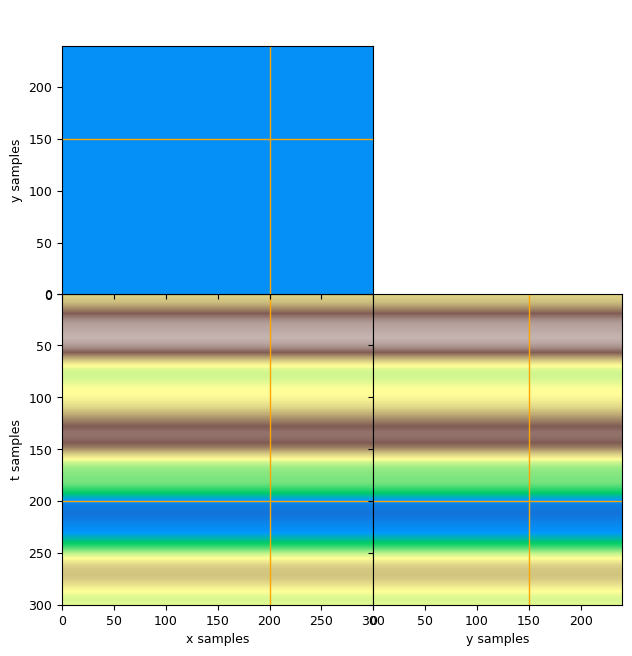

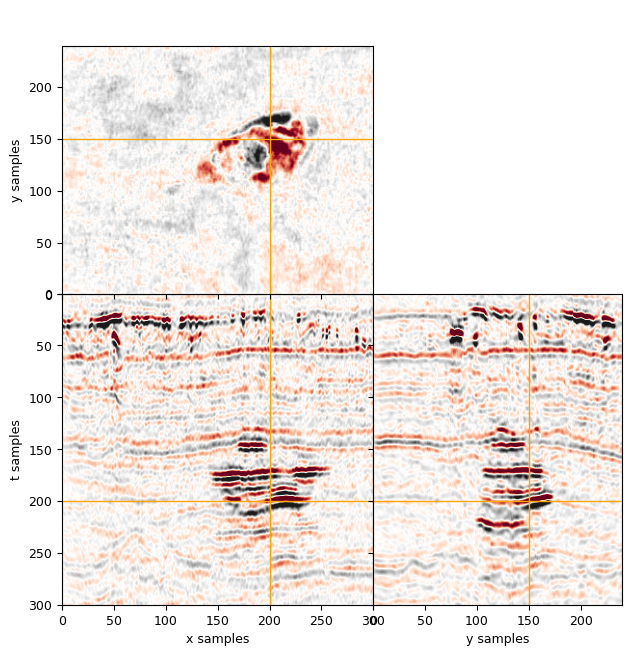

In [2]:
# Limits 
xmin, xmax = 0, 240
ymin, ymax = 0, 300
zmin, zmax = 300, 600

f = segyio.open('../../data/01p07ful.sgy')
d_ = segyio.cube(f).transpose(2, 1, 0)[zmin:zmax, ymin:ymax, xmin:xmax] 
d_tensor = torch.from_numpy(d_).float().float().ravel()

mback = np.load('../../data/Sleipner_impedance_model.npy')
mback= np.repeat(mback[:, :, np.newaxis], d_.shape[-1], axis=-1)[zmin:zmax, ymin:ymax]  #make 3D model
mback = torch.from_numpy(np.log(mback).astype('float32')).float()

wav = np.load('../../data/SLeip_wav_01.npy')

# Well-log data
mwell = np.log(np.load('../../data/Sleipner_impedance_log.npy'))[300:600]
vmin, vmax = np.percentile(np.exp(mwell), [1,99])

dims= d_.shape
dt = 0.002

# # Visualization
i, j, k = 200, 200, 150
explode_volume(np.exp(mback), i, j, k, figsize=(7, 6), cmap='terrain', vmin=vmin, vmax=vmax,  whspace=(0., -0.13))
explode_volume(d_, i, j, k, figsize=(7, 6),vmin=-1., vmax=1., cmap='RdGy', whspace=(0., -0.13))

## Data preparation

In [3]:
# General parameters
num_epochs = 300
print_evry = 50
learning_rate = 1e-2

coords = create_coords(dims).to(device)
d =  d_tensor.to(device)
mback_ =  mback.ravel().to(device)

# Modeling Operator
G = pylops.avo.poststack.PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
G_torch = pylops.torchoperator.TorchOperator(G, device=device)

## IntraSeismic model setup

In [4]:
# IntraSeismic model setup
with open("config_sleip.json") as f:
	config = json.load(f)
    
# IntraSeismic network 
net = create_model(n_input_dims=len(dims), n_output_dims=1, config=config).to(device)

print(net)
summary(net)

Sequential(
  (0): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 16, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.100000023841858, 'type': 'Hash'})
  (1): MLP(
    (layers_linears): ModuleList(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
    (output_linear): Linear(in_features=64, out_features=1, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Encoding: 1-1                          1,216,208
├─MLP: 1-2                               --
│    └─ModuleList: 2-1                   --
│    │    └─Linear: 3-1                  2,112
│    │    └─Linear: 3-2                  4,160
│    └─Linear: 2-2                       65
Total params: 1,222,545
Trainable params: 1,222,545
Non-trainable params: 0

## Training

In [5]:
# Initialize optimizer and losses
combined_parameters = list(net.parameters())
optimizer = torch.optim.Adam(combined_parameters, lr=learning_rate)

# Training Loop
total_train_time = 0
epoch_losses = []
net.train()
for epoch in range(1, num_epochs + 1):
    # net.train()
    loss, epoch_time = train_is_sb(coords, d, mback_, dims, G_torch,
                                   net, optimizer,
                                   alpha_mtv = 2e-9,
                                   beta = 1,
                                   l2 = True)
                                                                                       
    total_train_time += epoch_time
    epoch_losses.append(loss)
    net.eval()
    with torch.no_grad():
        delta_model = net(coords.to(device))
        model_ = delta_model.squeeze(1) + mback.ravel().to(device)
    
    if epoch % print_evry == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.6f}, Training Time: {total_train_time:.2f}s')

print(f'Training completed in {total_train_time:.3f} seconds.')

Epoch [50/300], Loss: 0.052602, Training Time: 1.32s
Epoch [100/300], Loss: 0.051543, Training Time: 1.60s
Epoch [150/300], Loss: 0.051232, Training Time: 1.89s
Epoch [200/300], Loss: 0.051230, Training Time: 2.17s
Epoch [250/300], Loss: 0.051037, Training Time: 2.46s
Epoch [300/300], Loss: 0.050985, Training Time: 2.74s
Training completed in 2.743 seconds.


Text(0.5, 1.0, 'Total loss')

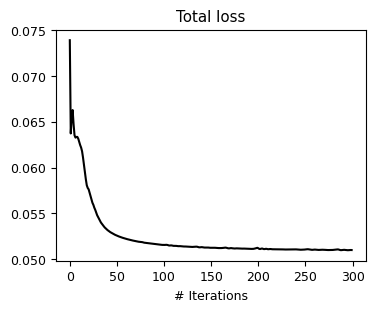

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(epoch_losses, 'k')
ax.set_xlabel('# Iterations')
ax.set_title('Total loss')

(<Figure size 1000x900 with 4 Axes>,
 (<AxesSubplot:xlabel='x samples', ylabel='t samples'>,
  <AxesSubplot:ylabel='y samples'>,
  <AxesSubplot:xlabel='y samples'>))

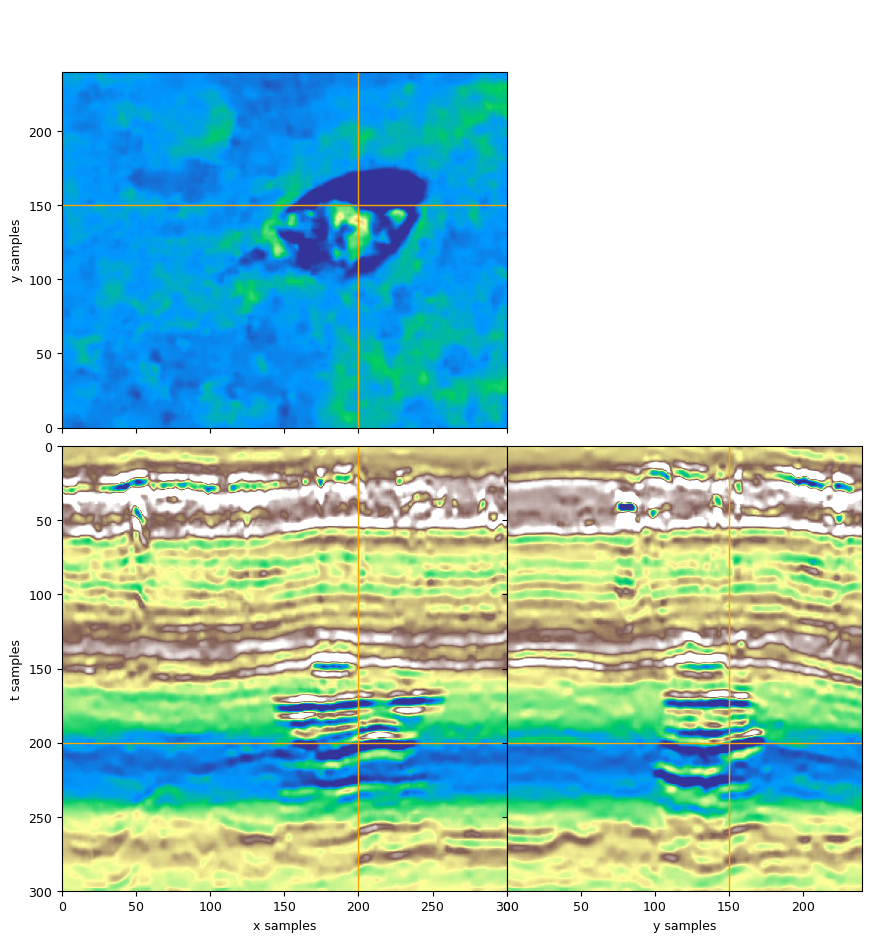

In [7]:
net.eval()
with torch.no_grad():
    delta_model = net(coords.to(device))
    model_ = delta_model.squeeze(1) + mback.ravel().to(device)

model_cpu = np.exp((model_).cpu().detach().numpy().reshape(*dims))
explode_volume(model_cpu, 200, j, k, figsize=(10, 9), cmap='terrain', vmin=vmin, vmax=vmax,  whspace=(0., -0.13))